In [4]:
drive_folder = "Machine_Unlearning_Drive/Cifar100Results/"

ssd_folder = "SSD/"

scrub_folder = "SCRUB/"

github_folder = "Machine_Unlearning/"

!pip install scikit-learn torch torchvision

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [5]:
import os
import requests
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, model_selection
import random

import torch
import json
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.models import resnet18

from Machine_Unlearning.Metrics.metrics import *

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device:", DEVICE.upper())

def seed_everything(seed):
  RNG = torch.Generator().manual_seed(seed)
  torch.manual_seed(seed)
  random.seed(seed)
  np.random.seed(seed)
  return RNG

SEED = 44
RNG = seed_everything(SEED)

Running on device: CPU


Running on device: CPU
Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


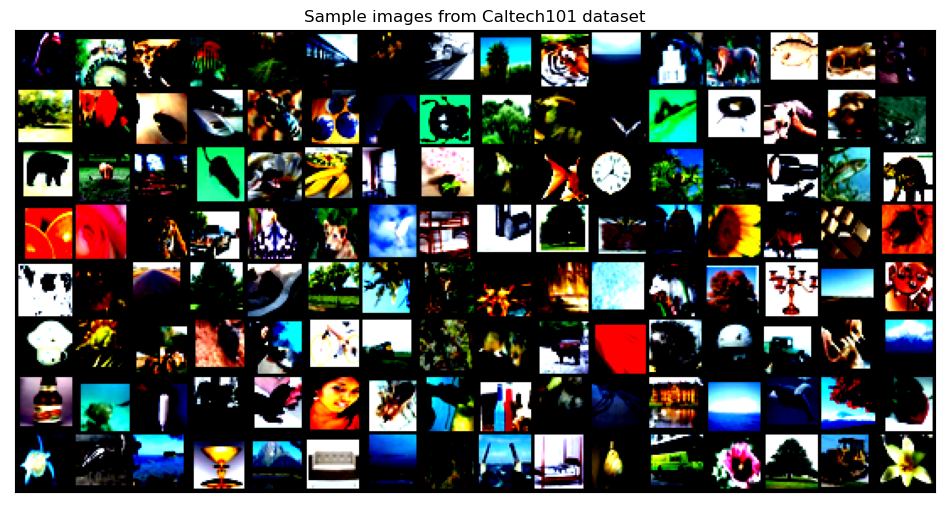

In [6]:
import torch as trch
import torchvision.datasets as dts
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.models import VGG16_Weights
from torchvision.utils import make_grid
import torch.nn as nn
import matplotlib.pyplot as plot
import scipy
import matplotlib.pyplot as plt


DEVICE = "cuda" if trch.cuda.is_available() else "cpu"
print("Running on device:", DEVICE.upper())



train_transform = transforms.Compose([
                         transforms.RandomCrop(32, padding=4),
                         transforms.RandomHorizontalFlip(),
                         transforms.ToTensor(), transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))])

test_transform = transforms.Compose([
                         transforms.ToTensor(),
                         transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
        ])




train_set = dts.CIFAR100(root='./data', download=True, train=True, transform=train_transform)
train_loader = trch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)

test_set = dts.CIFAR100(root='./data', download=True, train=False, transform=test_transform)
test_loader = trch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False)


RNG = seed_everything(1337)

cmodel = models.resnet18(weights=None, num_classes=100)
cmodel = cmodel.to(DEVICE)


images, labels = next(iter(train_loader))

fig, ax = plt.subplots(figsize=(12, 6))
plt.title("Sample images from Caltech101 dataset")
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
plt.show()


In [7]:
def accuracy(net, loader):
    """Return accuracy on a dataset given by the data loader."""
    correct = 0
    total = 0
    for i,(inputs, targets) in enumerate(loader):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        #print(i)
        outputs = net(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return correct / total

In [8]:
#This model has been trained using SGD with a learning rate of 0.1, momentum of 0.9 and weight decay of 5e-4.

numepchs = 50
lr = 0.1
criter = nn.CrossEntropyLoss()
optim = trch.optim.SGD(cmodel.parameters(), lr=lr,momentum = 0.9, weight_decay=5e-4)
scheduler = trch.optim.lr_scheduler.LinearLR(optim, start_factor=1.0, end_factor=0.001, total_iters=numepchs)
nttlstps = len(train_loader)
cmodel.train()
for epoch in range(numepchs):
    for x, (imgs, lbls) in enumerate(train_loader):
         imgs , lbls = imgs.to(DEVICE), lbls.to(DEVICE)
         #imgs = imgs.reshape(-1, 28*28)


         outp = cmodel(imgs)
         losses = criter(outp, lbls)

         optim.zero_grad()
         losses.backward()
         optim.step()
         if x % 100 == 0:
           print (f'Epochs [{epoch+1}/{numepchs}], Step[{x+1}/{nttlstps}], Losses: {losses.item():.4f}')
    scheduler.step()

In [10]:
torch.save(cmodel.state_dict(),github_folder+"CIFAR100_Resnet18.ckp")